In [1]:
import numpy as np
import pandas as pd
import os
import yaml

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter, LinearLocator

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

%matplotlib inline
from matplotlib import rcParams

In [2]:
# vars
adapt_methods = ['coral','al_layer']
gen_methods = ['irm','dro','coral','al_layer']
tasks = ['mortality','longlos','invasivevent','sepsis']
metrics = ['auc','auprc','ace_abs_logistic_log']
Ns = [100,500,1000,1500]

# paths
tables_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_adapt/tables/'
figures_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_adapt/figures/'
adapt_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_adapt'
gen_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/domain_gen'
base_fpath = '/hpf/projects/lsung/projects/mimic4ds/Experiments/baseline'

In [6]:
# Figure settings
y_axis = {
    'longlos':{
        'label':'Long LOS',
        'auc':{
            'lim':[0.6, 0.75],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.475, 0.575],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'label':'Calibration'
        },
    },
    'sepsis':{
        'label':'Sepsis',
        'auc':{
            'lim':[0.6, 0.8],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0, 0.4],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.02, 0.1],
            'label':'Calibration'
        },
    },
    'mortality':{
        'label':'Mortality',
        'auc':{
            'lim':[0.8, 0.95],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.3, 0.65],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.01, 0.05],
            'label':'Calibration'
        },
    },
    'invasivevent':{
        'label':'Invasive\nVentilation',
        'auc':{
            'lim':[0.8, 0.95],
            'label':'AUROC'
        },
        'auprc':{
            'lim':[0.35, 0.7],
            'label':'AUPRC'
        },
        'ace_abs_logistic_log':{
            'lim':[-0.01, 0.05],
            'label':'Calibration'
        },
    },
}

titles = {
    "irm":"IRM",
    "dro":"GroupDRO",
    "coral":"CORAL",
    "al_layer":"AL"
}

xticklabels = {
    "irm":['1e\n-1','1e\n0','1e\n1','1e\n2','1e\n3','1e\n4'],
    "dro":['1e\n-6','1e\n-5','1e\n-4','1e\n-3','1e\n-2','1e\n-1'],
    "coral":['1e\n-2','1e\n-1','1e\n0','1e\n1','1e\n2','1e\n3'],
    "al_layer":['1e\n-5','1e\n-4','1e\n-3','1e\n-2','1e\n-1','1e\n0']
}

In [7]:
alpha = 0.05
results = {
    "base":{
        "eval":pd.read_csv(f"{base_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test'"),
        "compare":pd.read_csv(f"{base_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test'"),
    },
    "gen":{
        "eval":pd.read_csv(f"{gen_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test' and group==1"),
        "compare":pd.read_csv(f"{gen_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test' and group==1"),
    },
    "adapt":{
        "eval":pd.read_csv(f"{adapt_fpath}/results/model_evaluation_{alpha}.csv").query("phase=='test' and group==1"),
        "compare":pd.read_csv(f"{adapt_fpath}/results/model_comparison_{alpha}.csv").query("phase=='test' and group==1"),
    },
}

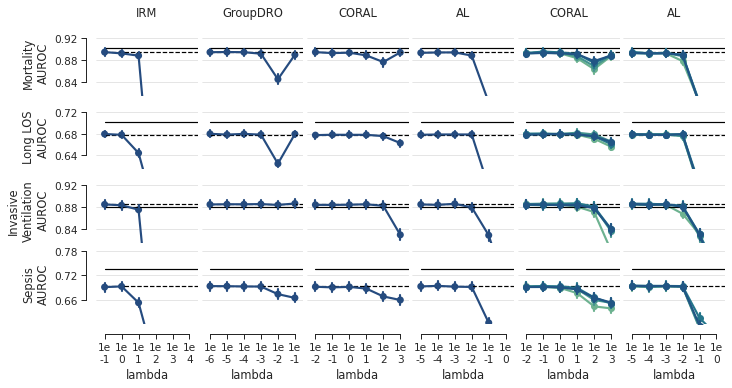

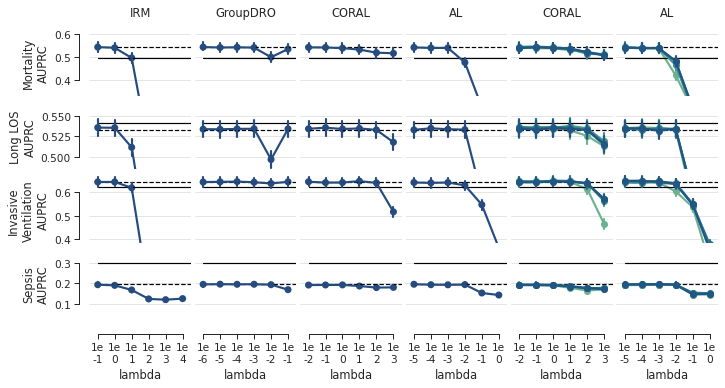

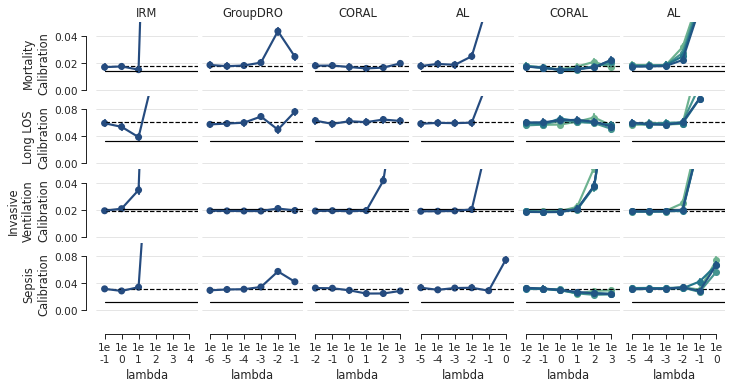

In [8]:
evaluation_method = 'avg'

for metric in metrics:
    fig, axes = plt.subplots(
        nrows=len(tasks),
        ncols=len(gen_methods+adapt_methods),
        figsize=(10,6)
    )
    plt.tight_layout(w_pad=-3,h_pad=-3,rect=[0.05,0.15,1,0.95])
    
    for r,task in enumerate(tasks):
        for c,method in enumerate(gen_methods+adapt_methods):
            if c<len(gen_methods):  
                df_gen = results['gen']['eval'].query(
                    "analysis_id==@task and \
                    train_method==@method and \
                    evaluation_method==@evaluation_method and \
                    metric==@metric and \
                    `lambda`!=-1"
                ).melt(
                    id_vars=['lambda'],
                    value_vars=['ci_lower','ci_med','ci_upper'],
                    value_name='performance'
                )
            else:
                df_adapt = results['adapt']['eval'].query(
                    "analysis_id==@task and \
                    train_method==@method and \
                    evaluation_method==@evaluation_method and \
                    metric==@metric and \
                    `lambda`!=-1"
                ).melt(
                    id_vars=['lambda','n_ood'],
                    value_vars=['ci_lower','ci_med','ci_upper'],
                    value_name='performance'
                )
            
            base = results['gen']['eval'].query(
                "analysis_id==@task and \
                train_method=='erm' and \
                evaluation_method==@evaluation_method and \
                metric==@metric"
            )['ci_med'].values[0]

            oracle = results['base']['eval'].query(
                "analysis_id==@task and \
                evaluation_method==@evaluation_method and \
                metric==@metric and \
                train_group=='2017 - 2019' and \
                eval_group=='2017 - 2019'"
            )['ci_med'].values[0]

            axes[r][c].plot(
                [0, 1e6],
                [base,base],
                'k--'
            )

            axes[r][c].plot(
                [0, 1e6],
                [oracle,oracle],
                'k-'
            )

            if c<len(gen_methods):
                sns.pointplot(
                    data = df_gen,
                    x = 'lambda',
                    y = 'performance',
                    ax = axes[r][c],
                    color = sns.color_palette("crest")[-1]
                )
            else:
                sns.pointplot(
                    data = df_adapt,
                    x = 'lambda',
                    y = 'performance',
                    hue = 'n_ood',
                    palette = 'crest',
                    ax = axes[r][c]
                )
                axes[r][c].get_legend().remove()
            
            ## Axes settings
            axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
            axes[r][c].grid(which='major', linewidth=0.5, axis='y')
            axes[r][c].set_ylim(
                y_axis[task][metric]['lim']
            )

            if r==0:
                axes[r][c].set_title(titles[method])

            if r==len(tasks)-1:
                axes[r][c].set_xticklabels(xticklabels[method])
            else:
                axes[r][c].set_xticklabels('')
                axes[r][c].set_xlabel('')
                axes[r][c].spines['bottom'].set_color('none')
                axes[r][c].tick_params(axis='x', length=0)

            if c==0:
                axes[r][c].set_ylabel(
                    f"{y_axis[task]['label']}\n{y_axis[task][metric]['label']}"
                )
            else:
                axes[r][c].set_yticklabels('')
                axes[r][c].set_ylabel('')
                axes[r][c].spines['left'].set_color('none')
                axes[r][c].tick_params(axis='y', length=0)
    
    sns.despine(offset=10, trim=True)
    plt.savefig(f"{figures_fpath}/lambda_sweep_{metric[:3]}.tif", dpi=300)
    plt.show()